In [1]:
import datetime
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from tqdm import tqdm

## for processing
import re
import nltk

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

2022-07-11 18:45:53.474730: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 18:45:53.475164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda()) 

[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
False


In [4]:
edmo = pd.read_csv('Disinformation-edmo.csv')
edmo['date']= pd.to_datetime(edmo['Date'])
edmo['class'] = '1'
edmo

/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '28.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '27.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '26.02.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/sit

,Date,Country,Title,Link,date,class
0,10.03.2022,"Portugal, Polígrafo",Video shows corpse moving during report on war...,https://poligrafo.sapo.pt/fact-check/video-mos...,2022-10-03,1
1,09.03.2022,"Italia, Facta News",This video was manipulated to misinform about ...,https://facta.news/immagine-modificata/2022/03...,2022-09-03,1
2,09.03.2022,"France, AFP Factuel","Beware, this video does not show an aerial com...",https://factuel.afp.com/doc.afp.com.324R8EH,2022-09-03,1
3,09.03.2022,"Italia, Facta News",The flag of Ukraine has not been hoisted on th...,https://facta.news/fuori-contesto/2022/03/09/s...,2022-09-03,1
4,09.03.2022,"Italia, Facta News",This is not a Ukrainian woman explaining on Ti...,https://facta.news/fuori-contesto/2022/03/09/q...,2022-09-03,1
...,...,...,...,...,...,...
346,24.02.2022,"Spain, Maldita.es","No, this video is not of the destruction of Ru...",https://maldita.es/malditobulo/20220224/no-est...,2022-02-24,1
347,24.02.2022,"Italy, Facta.news","Russia-Ukraine, Tg2 broadcasted a videogame an...",https://facta.news/fuori-contesto/2022/02/24/n...,2022-02-24,1
348,24.02.2022,"Italy, Facta.news",Video shows lightning not Russia invasion of U...,https://facta.news/fuori-contesto/2022/02/24/r...,2022-02-24,1
349,24.02.2022,"Germany, Correctiv",Russian ministry of defense said they are not ...,https://correctiv.org/faktencheck/2022/02/24/d...,2022-02-24,1


In [5]:
df = pd.read_csv('extracted_news_articles.csv')
factchecked = df.query("(clean_url == 'bbc.com') or (clean_url == 'bbc.co.uk') or (clean_url == 'cnn.com') or (clean_url == 'cbsnew.com') or (clean_url == 'economist.com') or (clean_url == 'cnbc.com') or (clean_url == 'euronews.com') or (clean_url == 'npr.org') or (clean_url == 'nytimes.com') or (clean_url == 'usatoday.com')")
factchecked
cls = '0'
factchecked['class'] = cls
factchecked

/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/2303743044.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factchecked['class'] = cls


,Unnamed: 0,title,author,published_date,published_date_precision,link,clean_url,excerpt,summary,rights,...,country,language,authors,media,is_opinion,twitter_account,_score,_id,used_params,class
36,36,War in Ukraine is 'not the United States' figh...,Celina Tebor,2022-05-24 07:00:08,full,https://www.usatoday.com/story/news/politics/2...,usatoday.com,Biden told Indo-Pacific leaders Tuesday that t...,US says Ukraine ultimately defines the end of ...,azcentral.com,...,US,en,['Celina Tebor'],https://www.gannett-cdn.com/presto/2022/05/20/...,False,@azcentral,17.586529,0aa0686fd05b650179d9b1ce63fc2414,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
46,46,Starbucks closes all its cafes in Russia,Aditi Sangal,2022-05-23 04:00:37,full,https://edition.cnn.com/europe/live-news/russi...,cnn.com,Coffee giant Starbucks says it has exited Russ...,"As the war in Ukraine rages on, up to 100 peop...",cnn.com,...,US,en,"['Aditi Sangal', 'Andrew Raine', 'Amy Woodyatt...",https://dynaimage.cdn.cnn.com/cnn/digital-imag...,False,NaN,17.535084,72616edb9eb88bc0343ab1aec784008a,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
47,47,3 months into the Russia-Ukraine war: What hap...,NPR Staff,2022-05-24 21:00:13,full,https://www.npr.org/2022/05/24/1100986158/3-mo...,npr.org,A roundup of key developments and the latest i...,Smoke and debris ascend after a strike at a fa...,npr.org,...,US,en,['Npr Staff'],https://media.npr.org/assets/img/2022/05/24/ge...,False,@NPR,17.529213,36d68cc8591d18676af4d3654588cdfe,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
53,53,"Russia blocking Ukrainian ports is ""clear blac...",Brad Lendon,2022-05-26 04:00:17,full,https://edition.cnn.com/europe/live-news/russi...,cnn.com,Russia is trying to 'blackmail' the internatio...,Storage silos and shipping cranes at the Port ...,cnn.com,...,US,en,"['Brad Lendon', 'Jack Guy', 'Hafsa Khalil']",https://dynaimage.cdn.cnn.com/cnn/digital-imag...,False,NaN,17.508972,03a695ca23848f2eb42ee11a3f4fec0f,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
55,55,200 bodies found in bombed Mariupol building; ...,"Celina Tebor\n, John Bacon",2022-05-24 07:00:08,full,https://www.usatoday.com/story/news/politics/2...,usatoday.com,200 decomposing bodies were found in the basem...,US says Ukraine ultimately defines the end of ...,"Copyright 2022, GANNETT",...,US,en,"['U', 'S', 'A', ' ', 'T', 'O', 'D', 'A', 'Y']",https://www.gannett-cdn.com/presto/2022/05/20/...,False,@usatoday,17.504000,023767a3390d5c26063b27e5c6ce79fc,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,9883,"Azovstal steel plant will be torn down, separa...","John Bacon\n, Celina Tebor",2022-05-18 07:00:09,full,https://www.usatoday.com/story/news/politics/2...,usatoday.com,The fall of Mariupol to\u00a0the Russians appe...,"Ukrainian orphans fled to Berlin, uncertain wh...","Copyright 2022, GANNETT",...,US,en,"['U', 'S', 'A', ' ', 'T', 'O', 'D', 'A', 'Y']",https://www.gannett-cdn.com/presto/2022/05/13/...,False,@usatoday,15.272007,3617d8d56e3ba40c7dfb59a3c6247662,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
9947,9933,First civil wedding in devastated Ukraine city...,NaN,2022-05-26 14:45:38,timezone unknown,https://www.euronews.com/2022/05/26/first-civi...,euronews.com,As wedding season gets under way in Ukraine de...,As wedding season gets under way in Ukraine de...,euronews.com,...,FR,en,[],https://static.euronews.com/articles/stories/0...,False,@euronews,15.266157,c5a2ce826894edfb906ce0ea8c653521,"{'q': 'War OR Ukraine OR Russia', 'lang': 'en'...",0
9966,9952,Ukraine war: Russia's jailed Navalny attacks i...,https://www.facebook.com/bbcnews,2022-05-24 11:18:08,full,https://www.bbc.com/news/world-europe-61564440,bbc.com,Russia's prominent opposition figure condemns ...,"By Paul KirbyBBC NewsMedia caption, Watch: Ale...",bbc.com,...,GB,en,['https://www.facebook.com/bbcnews'],https://ichef.bbci.co.uk/news/1024/bran

In [6]:
factchecked['published_date'] = factchecked['published_date'].loc[factchecked['published_date'] != 'news']
factchecked['published_date'] = factchecked['published_date'].loc[factchecked['published_date'] != 'world']

factchecked['published_date']= pd.to_datetime(factchecked['published_date'])


factchecked['date'] = factchecked['published_date'].dt.date
factchecked['Title'] = factchecked['title']

/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/4168484106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factchecked['published_date'] = factchecked['published_date'].loc[factchecked['published_date'] != 'news']
/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/4168484106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factchecked['published_date'] = factchecked['published_date'].loc[factchecked['published_date'] != 'world']
/var/folders/nj/214wqnhx71724jmsw9sjmrxr0

In [7]:
edmo

,Date,Country,Title,Link,date,class
0,10.03.2022,"Portugal, Polígrafo",Video shows corpse moving during report on war...,https://poligrafo.sapo.pt/fact-check/video-mos...,2022-10-03,1
1,09.03.2022,"Italia, Facta News",This video was manipulated to misinform about ...,https://facta.news/immagine-modificata/2022/03...,2022-09-03,1
2,09.03.2022,"France, AFP Factuel","Beware, this video does not show an aerial com...",https://factuel.afp.com/doc.afp.com.324R8EH,2022-09-03,1
3,09.03.2022,"Italia, Facta News",The flag of Ukraine has not been hoisted on th...,https://facta.news/fuori-contesto/2022/03/09/s...,2022-09-03,1
4,09.03.2022,"Italia, Facta News",This is not a Ukrainian woman explaining on Ti...,https://facta.news/fuori-contesto/2022/03/09/q...,2022-09-03,1
...,...,...,...,...,...,...
346,24.02.2022,"Spain, Maldita.es","No, this video is not of the destruction of Ru...",https://maldita.es/malditobulo/20220224/no-est...,2022-02-24,1
347,24.02.2022,"Italy, Facta.news","Russia-Ukraine, Tg2 broadcasted a videogame an...",https://facta.news/fuori-contesto/2022/02/24/n...,2022-02-24,1
348,24.02.2022,"Italy, Facta.news",Video shows lightning not Russia invasion of U...,https://facta.news/fuori-contesto/2022/02/24/r...,2022-02-24,1
349,24.02.2022,"Germany, Correctiv",Russian ministry of defense said they are not ...,https://correctiv.org/faktencheck/2022/02/24/d...,2022-02-24,1


In [8]:
factchecked['date'].value_counts().head(10)

2022-05-23    50
2022-05-24    45
2022-05-16    33
2022-05-18    27
2022-05-20    22
2022-05-19    22
2022-05-25    21
2022-05-21    21
2022-05-15    20
2022-05-26    19
Name: date, dtype: int64

In [9]:
print(f'the dataset contains {len(factchecked)} news articles')
print(f'the dataset contains {len(edmo)} news articles')

the dataset contains 343 news articles
the dataset contains 351 news articles


In [10]:
print(f'there are {len(set(factchecked.date))} categories in the dataset')
print(set(factchecked.date))

there are 14 categories in the dataset
{datetime.date(2022, 5, 19), datetime.date(2022, 5, 22), datetime.date(2022, 5, 16), datetime.date(2022, 5, 24), datetime.date(2022, 5, 25), datetime.date(2022, 5, 18), datetime.date(2022, 5, 20), datetime.date(2022, 5, 17), datetime.date(2022, 5, 27), datetime.date(2022, 5, 14), datetime.date(2022, 5, 23), datetime.date(2022, 5, 15), datetime.date(2022, 5, 21), datetime.date(2022, 5, 26)}


In [11]:
## filter categories
#df = df[ df["topic"].isin(['politics', 'news', 'world', 'opinion'])        ][["topic","summary"]]
## rename columns
#df = df.rename(columns={"category":"category", "headline":"text"})
## print 5 random rows

df = factchecked[["date","Title", "class"]]
df2 = edmo[["date","Title", "class"]]

df3 = df2.append(df)

df3['date'] = pd.to_datetime(df3['date'])

df3['date'] = df3['date'].dt.date

/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/2127328728.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df2.append(df)
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/pandas/core/indexes/base.py:2237: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_unique
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/pandas/core/indexes/base.py:3809: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._eng

In [12]:
df3

,date,Title,class
0,2022-10-03,Video shows corpse moving during report on war...,1
1,2022-09-03,This video was manipulated to misinform about ...,1
2,2022-09-03,"Beware, this video does not show an aerial com...",1
3,2022-09-03,The flag of Ukraine has not been hoisted on th...,1
4,2022-09-03,This is not a Ukrainian woman explaining on Ti...,1
...,...,...,...
9897,2022-05-18,"Azovstal steel plant will be torn down, separa...",0
9947,2022-05-26,First civil wedding in devastated Ukraine city...,0
9966,2022-05-24,Ukraine war: Russia's jailed Navalny attacks i...,0
9996,2022-05-16,Moscow residents react to McDonald's leaving R...,0


In [13]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [14]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
df3["title_clean"] = df3["Title"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df3.head()

,date,Title,class,title_clean
0,2022-10-03,Video shows corpse moving during report on war...,1,video show corpse moving report war ukraine
1,2022-09-03,This video was manipulated to misinform about ...,1,video manipulated misinform war ukraine
2,2022-09-03,"Beware, this video does not show an aerial com...",1,beware video show aerial combat ukraine 2022
3,2022-09-03,The flag of Ukraine has not been hoisted on th...,1,flag ukraine hoisted royal statue liberty
4,2022-09-03,This is not a Ukrainian woman explaining on Ti...,1,ukrainian woman explaining tiktok drive abando...


In [16]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [17]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["ukraine"], topn=3)

[('russia', 0.7371844053268433),
 ('belarus', 0.7180590629577637),
 ('ukrainian', 0.6930267810821533)]

In [18]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [19]:
dic_clusters = {}
dic_clusters["0"] = get_similar_words(['minister', 'civilian','refugee','migrant','displaced', 'russia', 'ukraine'], top=30, nlp=nlp)
dic_clusters["1"] = get_similar_words(['military','troops','tanks','nuclear', 'president','biden','putin'], top=30, nlp=nlp)

In [20]:
## print top 5 closest words
print('Top words per label:')
for k,v in dic_clusters.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
0              ..... ['refugee', 'afghan', 'foreign', 'albania', 'immigrants']
1              ..... ['war', 'weapons', 'force', 'bush', 'clinton']


/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/1230355524.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_60417/1230355524.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dt

<IPython.core.display.Javascript object>


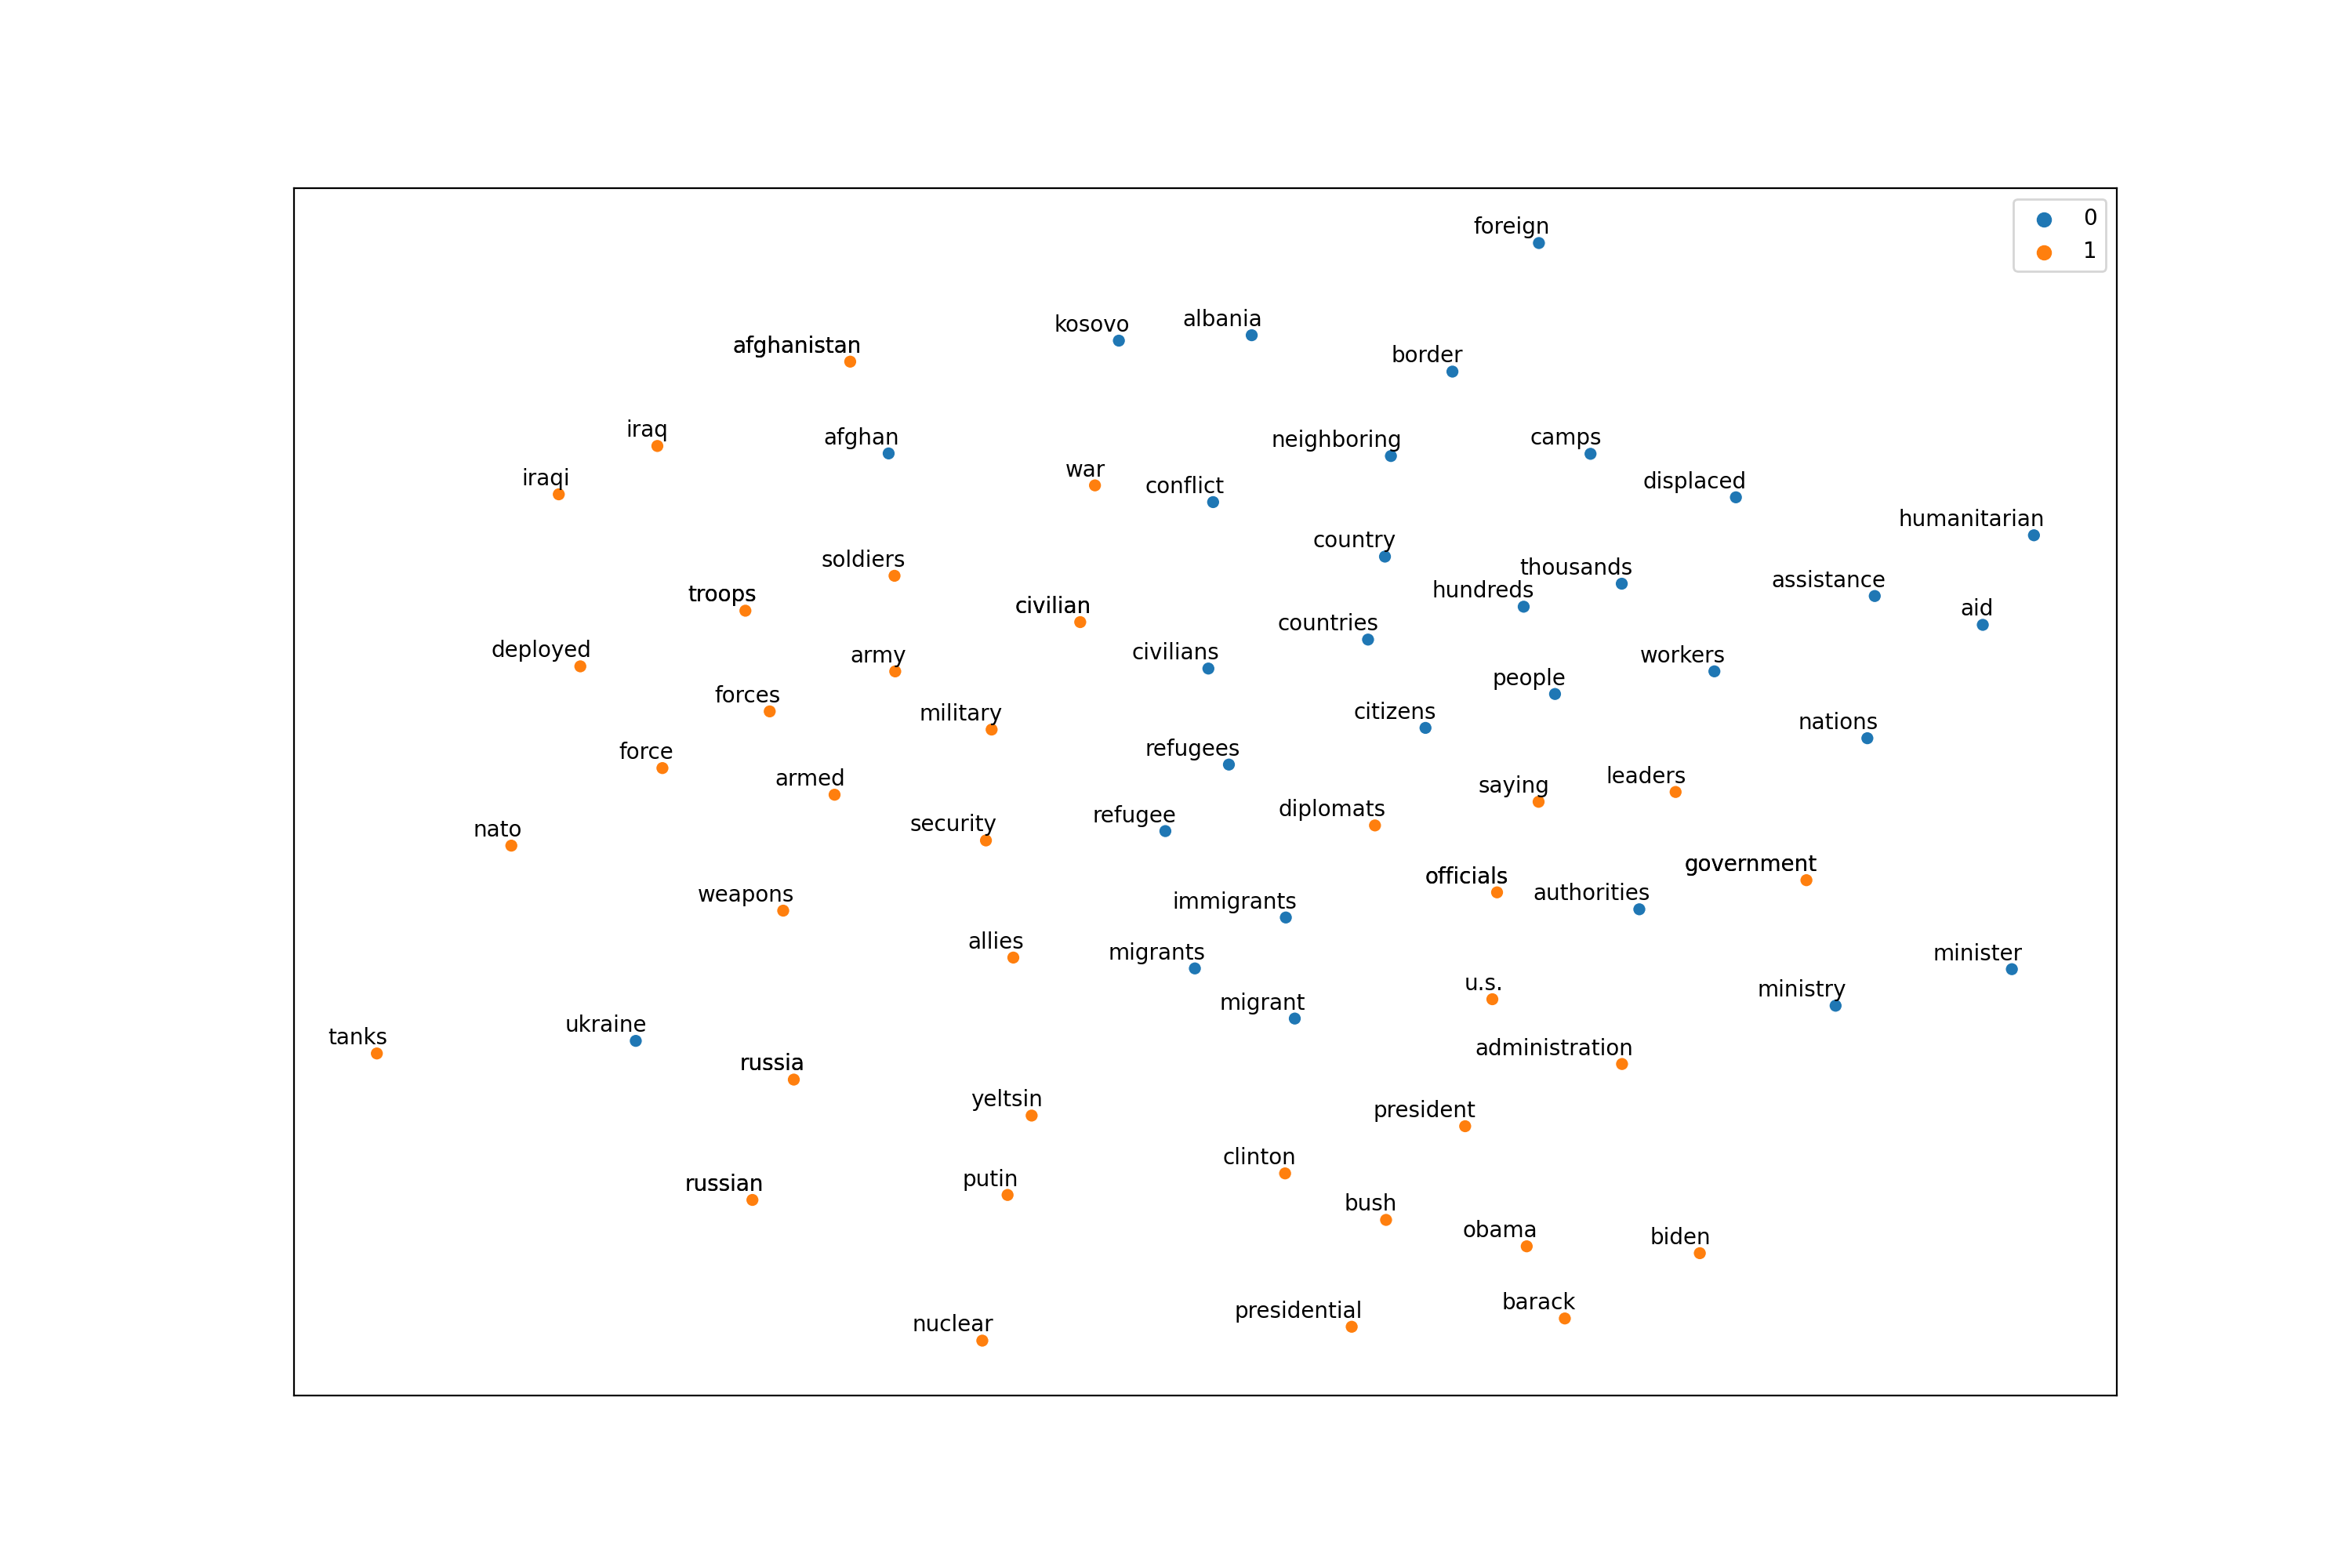

In [21]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_GloVe = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf_GloVe = dtf_GloVe.append(dtf_group)
        
## plot
%matplotlib notebook
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=dtf_GloVe, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf_GloVe)):
    ax.annotate(dtf_GloVe.index[i], xy=(dtf_GloVe["x"].iloc[i], dtf_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

In [22]:
%matplotlib inline

In [23]:
## for BERT
import transformers
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

In [24]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [25]:
%%time
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df3["title_clean"])]

 82%|█████████████████████████████████▋       | 570/694 [01:16<00:16,  7.36it/s]<timed exec>:2: RuntimeWarning: Mean of empty slice.
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|█████████████████████████████████████████| 694/694 [01:32<00:00,  7.49it/s]

CPU times: user 6min 1s, sys: 5.57 s, total: 6min 6s
Wall time: 1min 32s


In [26]:
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)
X.shape

(694, 768)

In [27]:
X

array([[ 0.23247035,  0.49490207,  0.4099451 , ..., -0.376134  ,
         0.25016937, -0.06188456],
       [ 0.38162622,  0.43167943,  0.15335329, ..., -0.1442701 ,
         0.09778   ,  0.41400343],
       [ 0.09749899,  0.20257361,  0.4182057 , ..., -0.28035423,
         0.02249802,  0.52891773],
       ...,
       [-0.393579  ,  0.1651066 ,  0.7380147 , ..., -0.22269003,
        -0.07348159,  0.13733152],
       [ 0.07795764, -0.02557188,  0.64672023, ..., -0.29705012,
         0.10393231, -0.00102776],
       [-0.33376712,  0.1892406 ,  0.8625749 , ..., -0.11537485,
         0.0477809 ,  0.20239916]], dtype=float32)

In [28]:
# Create y as {label:mean_vector}
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.24it/s]


In [29]:
dic_clusters

{'0': ['refugee',
  'afghan',
  'foreign',
  'albania',
  'immigrants',
  'displaced',
  'hundreds',
  'countries',
  'humanitarian',
  'border',
  'nations',
  'refugees',
  'russian',
  'ministry',
  'assistance',
  'people',
  'aid',
  'neighboring',
  'authorities',
  'afghanistan',
  'troops',
  'camps',
  'officials',
  'workers',
  'citizens',
  'government',
  'migrant',
  'thousands',
  'minister',
  'russia',
  'kosovo',
  'country',
  'conflict',
  'migrants',
  'civilian',
  'civilians',
  'ukraine'],
 '1': ['war',
  'weapons',
  'force',
  'bush',
  'clinton',
  'security',
  'u.s.',
  'president',
  'saying',
  'diplomats',
  'nuclear',
  'army',
  'obama',
  'military',
  'forces',
  'yeltsin',
  'biden',
  'administration',
  'russian',
  'iraqi',
  'nato',
  'tanks',
  'putin',
  'presidential',
  'armed',
  'afghanistan',
  'troops',
  'officials',
  'government',
  'barack',
  'soldiers',
  'russia',
  'leaders',
  'deployed',
  'iraq',
  'civilian',
  'allies']}

In [30]:
dic_y['0'].shape

(768,)

## Prediction

In [31]:
def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if len(np.where(np.isnan(X))[0])>0 or len(np.where(np.isnan(X))[1])>0:
        return np.nan_to_num(X)

In [32]:
## compute cosine similarities
## Output matrix with shape: number of news x number of labels (3, Entertainment/Politics/Tech). To put it another way, each row will represent an article and contain one similarity score for each target cluster.
similarities = np.array([metrics.pairwise.cosine_similarity(fix_NAN_inf_values(X), y.reshape(1,-1)).T.tolist()[0] for y in dic_y.values()]).T
print(similarities.shape)

## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity   ###############################################################################################################
    if sum(similarities[i]) == 0:
        similarities[i] = [0]*len(labels)
        similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

(694, 2)


Accuracy: 0.49
Detail:
              precision    recall  f1-score   support

           0       0.49      0.57      0.53       343
           1       0.49      0.40      0.44       351

    accuracy                           0.49       694
   macro avg       0.49      0.49      0.49       694
weighted avg       0.49      0.49      0.48       694



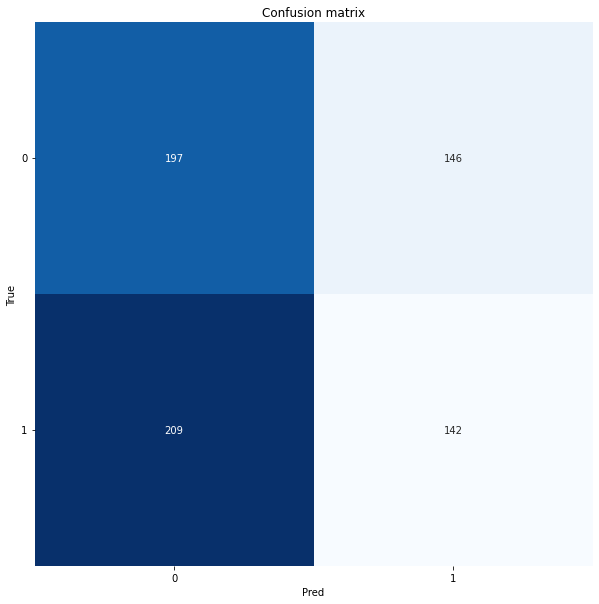

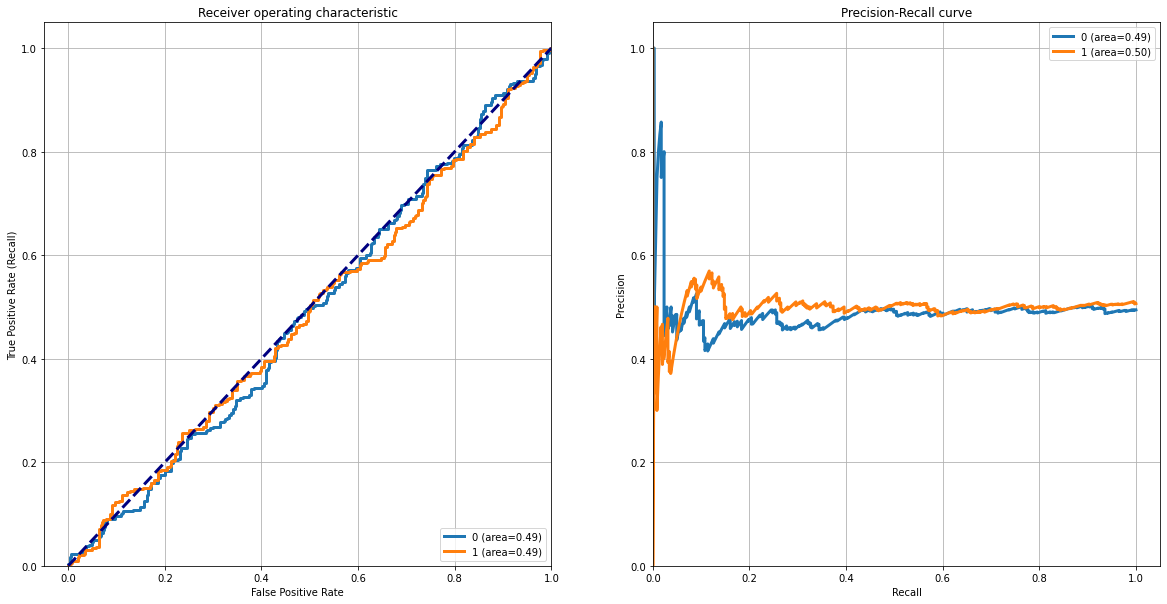

In [33]:
y_test = df3["class"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
#auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
#print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3,  label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [157]:
index = 7
summary_instance = df3["title_clean"].iloc[index]
print("True:", y_test[index], "--> Pred:", predicted[index], "| Similarity:", round(np.max(predicted_prob[index]),2))
print(summary_instance)

True: 1 --> Pred: 0 | Similarity: 0.52
photo two men fake weapon russian invasion ukraine


In [159]:
%matplotlib notebook

In [151]:
def embedding_bert(x, tokenizer=None, nlp=None):
    '''
    Creates a feature matrix (num_docs x vector_size)
    :parameter
        :param x: string or list
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
        :param log: bool - print tokens
    :return
        vector or matrix 
    '''
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') if tokenizer is None else tokenizer
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased') if nlp is None else nlp
    
    ## single word --> vec (size,)
    if (type(x) is str) and (len(x.split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp).reshape(-1)
    
    ## list of words --> matrix (n, size)
    elif (type(x) is list) and (type(x[0]) is str) and (len(x[0].split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
    
    ## list of lists of words --> matrix (n mean vectors, size)
    elif (type(x) is list) and (type(x[0]) is list):
        lst_mean_vecs = [utils_bert_embedding(lst, tokenizer, nlp).mean(0) for lst in x]
        X = np.array(lst_mean_vecs)
    
    ## single text --> matrix (n words, size)
    elif (type(x) is str) and (len(x.split()) > 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
        
    ## list of texts --> matrix (n mean vectors, size)
    else:
        lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in x]
        X = np.array(lst_mean_vecs)
    return X

In [152]:
## create embedding Matrix
y = np.concatenate([embedding_bert(v, tokenizer, nlp) for v in dic_clusters.values()])
X = embedding_bert(summary_instance, tokenizer, nlp).mean(0).reshape(1,-1)
M = np.concatenate([y,X])

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
M = pca.fit_transform(M)
y, X = M[:len(y)], M[len(y):]

## create dtf clusters
df = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(df) + len(v)
    df_group = pd.DataFrame(y[len(df):size], columns=["x","y"], index=v)
    df_group["cluster"] = k
    df = df.append(df_group)

## plot clusters
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(df)):
    ax.annotate(df.index[i], 
               xy=(df["x"].iloc[i],df["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## add txt_instance
ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)

## calculate similarity
sim_matrix = metrics.pairwise.cosine_similarity(X, y)

## add top similarity
for row in range(sim_matrix.shape[0]):
    ### sorted {keyword:score}
    dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
    dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
    ### plot lines
    for k in dict(list(dic_sim.items())[0:5]).keys():
        p1 = [X[row][0], X[row][1]]
        p2 = [y[k][0], y[k][1]]
        ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
plt.show()

/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ysojdehei/opt/anaconda3/envs/GRADSCHOOL/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/nj/214wqnhx71724jmsw9sjmrxr0000gn/T/ipykernel_66863/483880158.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_group)


ValueError: Shape of passed values is (33, 2), indices imply (37, 2)

In [153]:
%matplotlib notebook

In [154]:
df.shape

(37, 3)

In [277]:
y

array([[ 6.2821684 , -7.6809497 ],
       [ 6.249312  , -7.6660285 ],
       [ 6.169478  , -7.691093  ],
       [ 6.0885305 , -7.6861243 ],
       [ 6.034368  , -7.722451  ],
       [ 5.9618845 , -7.676295  ],
       [ 5.8964553 , -7.6574373 ],
       [ 5.8716693 , -7.5694723 ],
       [ 5.7691255 , -7.5137963 ],
       [ 5.719372  , -7.454459  ],
       [ 5.7568974 , -7.2969074 ],
       [ 5.7528753 , -7.0960674 ],
       [ 5.7751136 , -7.028251  ],
       [ 5.7986984 , -7.0265765 ],
       [ 5.812372  , -6.9514217 ],
       [ 5.825753  , -6.9681315 ],
       [ 5.945726  , -6.934718  ],
       [ 6.065856  , -6.947734  ],
       [ 6.2392955 , -6.736844  ],
       [ 6.536086  , -7.0636024 ],
       [ 6.6725664 , -7.0196586 ],
       [ 6.694524  , -7.051807  ],
       [ 6.758508  , -7.0142217 ],
       [ 6.753086  , -6.903746  ],
       [ 6.7854443 , -6.8096533 ],
       [ 6.7227855 , -6.8024426 ],
       [ 6.4514613 , -6.515215  ],
       [ 6.6637135 , -6.4135876 ],
       [ 6.6138535 ,